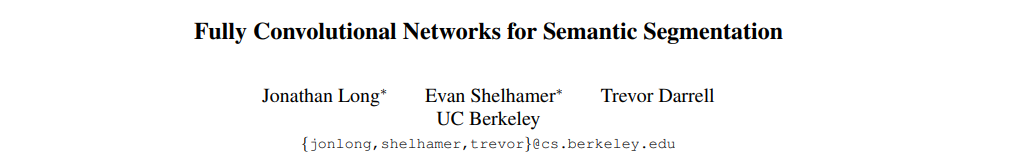

In [60]:
import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
 
print('Tensorflow version ' + tf.__version__)

Tensorflow version 2.5.0


class는 총 12개이며, annotation image의 픽셀값은 각 class에 해당되는 값으로 되어있습니다.

In [61]:
class_names = ['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 'pedestrian', 'bicyclist', 'void']

**이미지를 불러올 경로**

In [62]:
train_image_path = 'FCN_dataset/images_prepped_train/'
train_label_path = 'FCN_dataset/annotations_prepped_train/'
test_image_path = 'FCN_dataset/images_prepped_test/'
test_label_path = 'FCN_dataset/annotations_prepped_test/'
 
BATCH_SIZE = 64

**Dataset을 위한 함수 정의**

In [63]:
def map_filename_to_image_and_mask(t_filename, a_filename, height=224, width=224):
    '''
    다음을 통해 데이터 세트를 사전 처리합니다.:
        * 입력 이미지 및 레이블 맵 크기 조정
        * 입력 이미지 픽셀 정규화
        * 레이블 맵을 (height, width, 1)에서 (height, width, 12)로 재구성
    
    Args:
        t_filename(string) -- raw input image의 경로
        a_filename(string) -- raw annotation (label map) file의 경로
        height(int) -- 크기를 조정할 height(픽셀 단위)
        width(int) -- 크기를 조정할 width(픽셀 단위)
    
    Returns:
        image(tensor) -- 사전 처리된 이미지
        annotation(tensor) -- 사전 처리된 주석
    '''
 
    # Convert image and mask files to tensors
    img_raw = tf.io.read_file(t_filename)
    anno_raw = tf.io.read_file(a_filename)
    
    image = tf.image.decode_jpeg(img_raw)
    annotation = tf.image.decode_jpeg(anno_raw)
 
    # Resize image and segmentation mask
    image = tf.image.resize(image, (height, width,))
    annotation = tf.image.resize(annotation, (height, width,))
    image = tf.reshape(image, (height, width, 3,))
    annotation = tf.cast(annotation, dtype=tf.int32)
    annotation = tf.reshape(annotation, (height, width, 1,))
    stack_list = []
 
    # Reshape segmentation masks
    for c in range(len(class_names)):
        mask = tf.equal(annotation[:,:,0], tf.constant(c))
        stack_list.append(tf.cast(mask, dtype=tf.int32))
    
    annotation = tf.stack(stack_list, axis=2) # 레이블 맵을 클래스 수에 따라 다차원 배열로 재구성합니다. 
 
    # Normalize pixels in the input image
    image = image / 127.5
    image -= 1
 
    return image, annotation # 전처리된 이미지와 레이블맵을 반환
 
def get_dataset_slice_paths(image_dir, label_map_dir):
    '''
    이미지 및 레이블 맵 경로 목록을 생성합니다.
  
    Args:
        image_dir (string) -- 입력 이미지 디렉토리 경로
        label_map_dir (string) -- 레이블 맵 디렉토리의 경로
 
    Returns:
        image_paths (list of strings) -- 각 이미지 파일의 경로
        label_map_paths (list of strings) -- 각 레이블 맵의 경로
    '''
 
    image_file_list = os.listdir(image_dir)
    label_map_file_list = os.listdir(label_map_dir)
    
    image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]
    label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]
 
    return image_paths, label_map_paths
 
def get_training_dataset(image_paths, label_map_paths):
    '''
    Prepares shuffled batches of the training set.
  
    Args:
        image_dir (string) -- 입력 이미지 디렉토리 경로
        label_map_dir (string) -- 레이블 맵 디렉토리의 경로
 
    Returns:
        전처리된 훈련 세트를 포함하는 tf 데이터 세트
    '''
    training_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
    training_dataset = training_dataset.map(map_filename_to_image_and_mask)
    training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True) # 반복할 때마다 데이터셋을 다시 섞음
    training_dataset = training_dataset.batch(BATCH_SIZE)
    training_dataset = training_dataset.repeat()
    training_dataset = training_dataset.prefetch(-1) # 데이터셋을 사전에 로드(preload)하여 모델 학습 시간을 최적화합니다.
 
    return training_dataset
 
def get_validation_dataset(image_paths, label_map_paths):
    '''
    Prepares shuffled batches of the validation set.
  
    Args:
        image_dir (string) -- 입력 이미지 디렉토리 경로
        label_map_dir (string) -- 레이블 맵 디렉토리의 경로
 
    Returns:
        전처리된 훈련 세트를 포함하는 tf 데이터 세트
    '''
    validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
    validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
    validation_dataset = validation_dataset.batch(BATCH_SIZE)
    validation_dataset = validation_dataset.repeat()
 
    return validation_dataset

In [64]:
# get the paths to the images
training_image_paths, training_label_map_paths = get_dataset_slice_paths(train_image_path, train_label_path)
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths(test_image_path, test_label_path)

# generate the train and valid sets
training_dataset = get_training_dataset(training_image_paths, training_label_map_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_label_map_paths)

segmentation 색상을 지정한다

In [65]:
# generate a list that contains one color for each class
colors = sns.color_palette(None, len(class_names))
 
# 클래스 이름과 해당 클래스에 할당된 정규화된 RGB 튜플을 출력합니다. 
# 정규화된 RGB 튜플의 값은 후속 함수에서 255와 곱하여 (0,0,0)에서 (255,255,255)의 RGB 값으로 변환됩니다
for class_name, color in zip(class_names, colors):
    print(f'{class_name} -- {color}')

sky -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
building -- (1.0, 0.4980392156862745, 0.054901960784313725)
column/pole -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
road -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
side walk -- (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
vegetation -- (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
traffic light -- (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
fence -- (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
vehicle -- (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
pedestrian -- (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
bicyclist -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
void -- (1.0, 0.4980392156862745, 0.054901960784313725)


**시각화를 위한 함수**

In [66]:
# Visualization Utilities
 
def fuse_with_pil(images):
    '''
    빈 이미지를 만들고 입력 이미지를 붙여 넣습니다.
 
    Args:
        images (list of numpy arrays) - 붙여넣을 이미지의 numpy 배열 표현
  
    Returns:
        이미지를 포함하는 PIL 이미지 객체
    '''
 
    widths = (image.shape[1] for image in images)
    heights = (image.shape[0] for image in images)
    total_width = sum(widths)
    max_height = max(heights)
 
    new_im = PIL.Image.new('RGB', (total_width, max_height))
 
    x_offset = 0
    for im in images:
        pil_image = PIL.Image.fromarray(np.uint8(im))
        new_im.paste(pil_image, (x_offset,0))
        x_offset += im.shape[1]
  
    return new_im
 
 
def give_color_to_annotation(annotation):
    '''
    2차원 annotation을 (height, width, 3)인 3차원(색상채널 포함) numpy 배열로 변환합니다. 
    레이블 값에 255를 곱하고 이 축에 배치하여 주석에 색상을 지정합니다.
 
    Args:
        annotation (numpy array) - 레이블 맵 배열
  
    Returns:
        추가 색상 채널/축이 있는 주석 배열
    '''
    seg_img = np.zeros((annotation.shape[0], annotation.shape[1], 3)).astype('float')
  # annotation의 크기와 동일한 형태로 3개의 채널을 가지는 0으로 채워진 numpy 배열을 생성합니다. 
    for c in range(12):
        segc = (annotation == c)
        seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
        seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
        seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
    return seg_img
 
 
def show_predictions(image, labelmaps, titles, iou_list, dice_score_list):
    '''
    Displays the images with the ground truth and predicted label maps
 
    Args:
        image (numpy array) -- the input image
        labelmaps (list of arrays) -- contains the predicted and ground truth label maps
        titles (list of strings) -- display headings for the images to be displayed
        iou_list (list of floats) -- the IOU values for each class
        dice_score_list (list of floats) -- the Dice Score for each vlass
    '''
 
    true_img = give_color_to_annotation(labelmaps[1])
    pred_img = give_color_to_annotation(labelmaps[0])
 
    image = image + 1
    image = image * 127.5
    images = np.uint8([image, pred_img, true_img])
 
    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
    metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
    display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
    display_string = "\n\n".join(display_string_list) 
 
    plt.figure(figsize=(15, 4))
 
    for idx, im in enumerate(images):
        plt.subplot(1, 3, idx+1)
        if idx == 1:
            plt.xlabel(display_string)
        plt.xticks([])
        plt.yticks([])
        plt.title(titles[idx], fontsize=12)
        plt.imshow(im)
 
 
def show_annotation_and_image(image, annotation):
    '''
    Displays the image and its annotation side by side
 
    Args:
        image (numpy array) -- the input image
        annotation (numpy array) -- the label map
    '''
    new_ann = np.argmax(annotation, axis=2)
    seg_img = give_color_to_annotation(new_ann)
  
    image = image + 1
    image = image * 127.5
    image = np.uint8(image)
    images = [image, seg_img]
  
    images = [image, seg_img]
    fused_img = fuse_with_pil(images)
    plt.imshow(fused_img)
 
 
def list_show_annotation(dataset):
    '''
    Displays images and its annotations side by side
 
    Args:
        dataset (tf Dataset) - batch of images and annotations
    '''
 
    ds = dataset.unbatch()
    ds = ds.shuffle(buffer_size=100)
 
    plt.figure(figsize=(25, 15))
    plt.title("Images And Annotations")
    plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)
 
    # we set the number of image-annotation pairs to 9
    # feel free to make this a function parameter if you want
    for idx, (image, annotation) in enumerate(ds.take(9)):
        plt.subplot(3, 3, idx + 1)
        plt.yticks([])
        plt.xticks([])
        show_annotation_and_image(image.numpy(), annotation.numpy())

Dataset 이미지 시각화

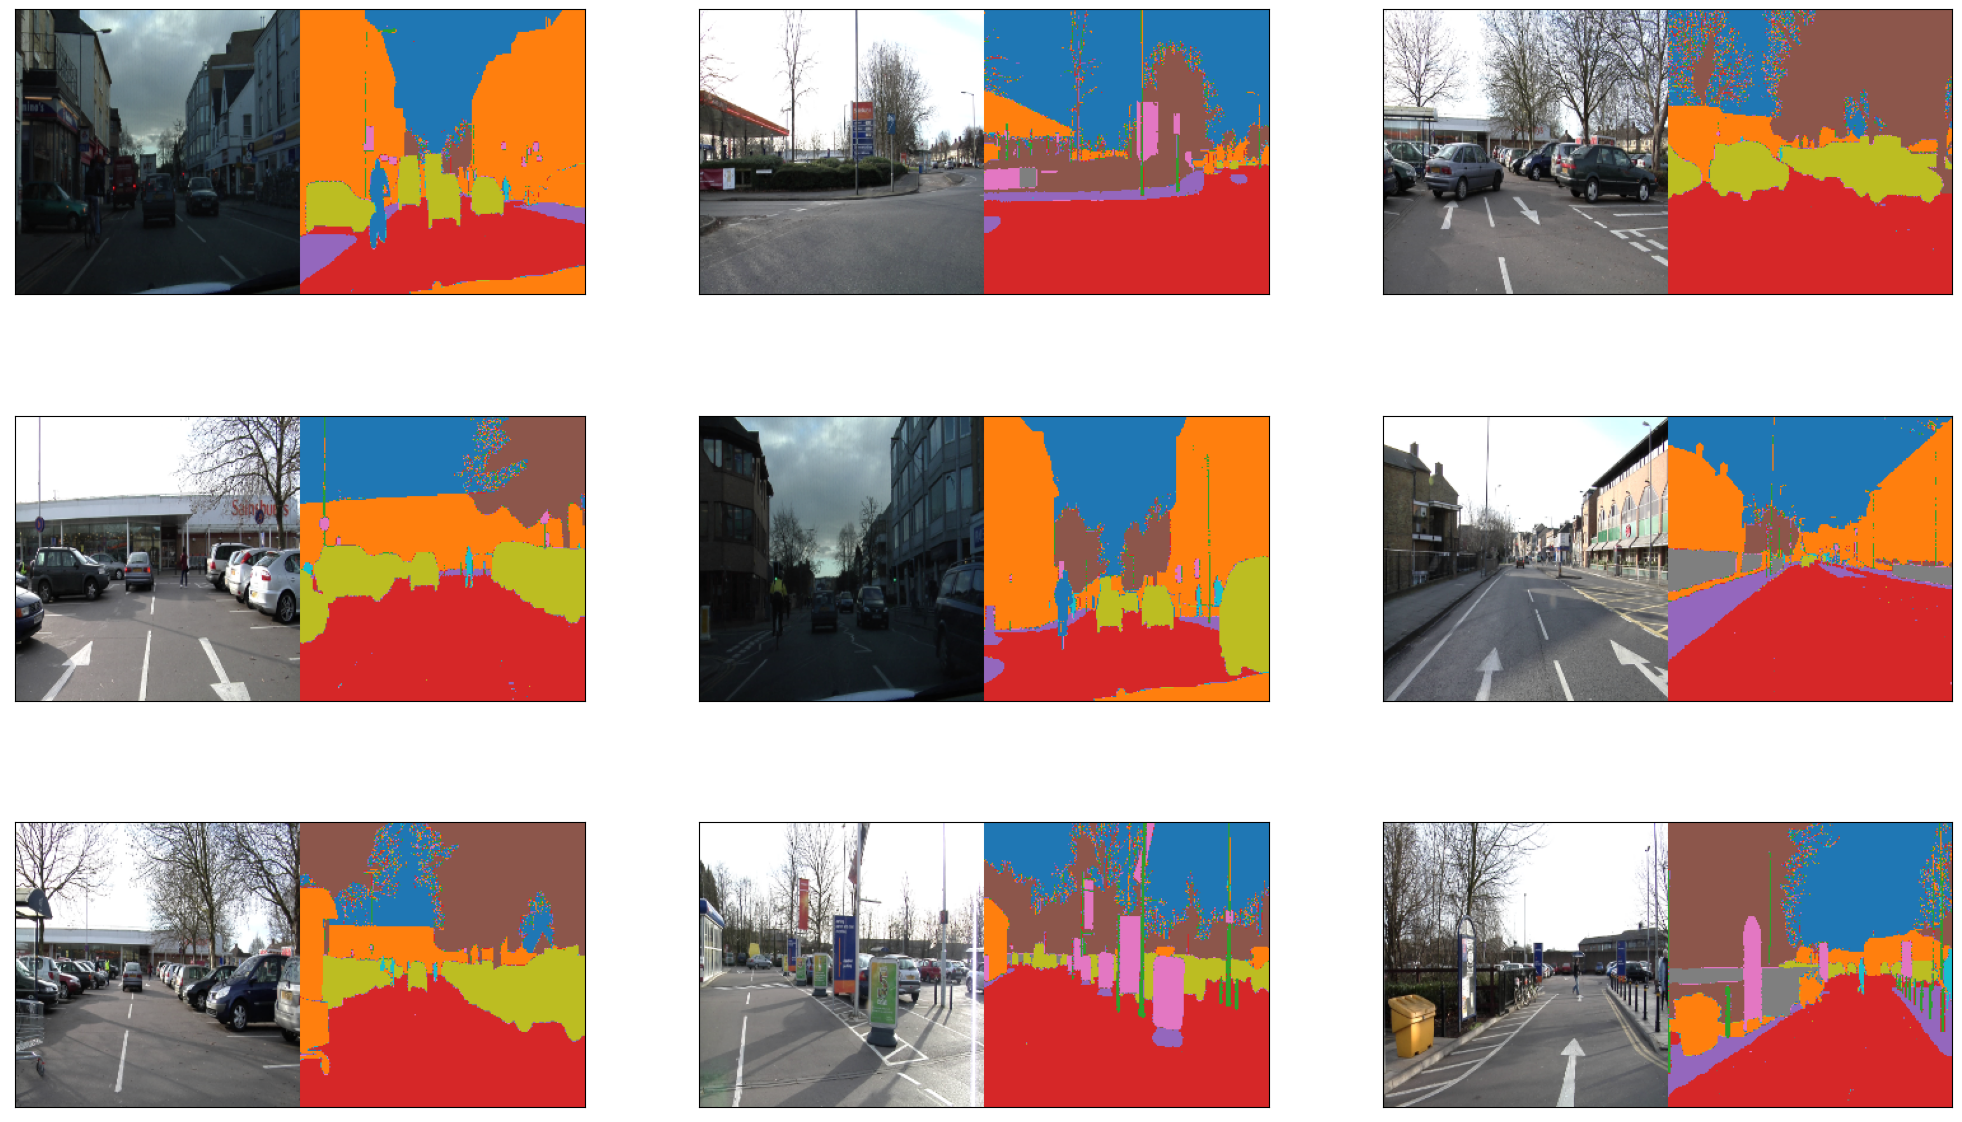

In [67]:
list_show_annotation(training_dataset)

Encoder

In [68]:
def block(x, n_convs, filters, kernel_size, activation, pool_size, pool_stride, block_name):
    '''
    Defines a block in the VGG block
 
    Args:
        x(tensor) -- 입력 이미지
        n_convs(int) -- 추가할 컨벌루션 레이어 수
        filters(int) -- 컨벌루션 레이어에 대한 필터 수
        activation(string or object) -- 컨볼루션에서 사용할 활성화
        pool_size(int) -- 풀링 레이어의 크기
        pool_stride(int) -- 풀링 레이어의 보폭
        block_name(string) -- 블록의 이름
    
    Returns:
        컨볼루션의 최대 풀링된 출력을 포함하는 텐서
    '''
    for i in range(n_convs):
        x = tf.keras.layers.Conv2D(filters=filters,
                                   kernel_size=kernel_size,
                                   activation=activation,
                                   padding='same',
                                   name=f'{block_name}_conv{i+1}')(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=pool_size,
                                     strides=pool_stride,
                                     name=f'{block_name}_pool{i+1}')(x)
    
    return x

학습된 VGG-16의 weight를 다운받습니다

In [69]:
import urllib.request

url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
filename = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
urllib.request.urlretrieve(url, filename)
 
# assign to a variable
vgg_weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

**VGG-16 Network 구현**
<br>
입력의 shape는 (224,224,3)이며, block 함수를 통해서 VGG-16 네트워크를 구현합니다.

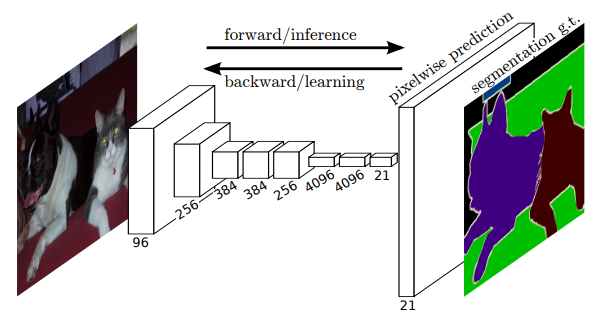

In [70]:
def VGG_16(image_input):
    '''
    This function defines the VGG encoder.
 
    Args:
        image_input(tensor) -- 배치 단위 이미지
    
    Returns:
        tuple of tensors -- 모든 인코더 블록과 최종 컨볼루션 레이어의 출력
    '''
 
    # create 5 blocks with increasing filters at each stage
    x = block(image_input, n_convs=2, filters=64, kernel_size=(3,3), activation='relu',
              pool_size=(2,2), pool_stride=(2,2),
              block_name='block1')
    p1 = x # (112, 112, 64)
 
    x = block(x, n_convs=2, filters=128, kernel_size=(3,3), activation='relu',
              pool_size=(2,2), pool_stride=(2,2),
              block_name='block2')
    p2 = x # (56, 56, 128)
 
    x = block(x, n_convs=3, filters=256, kernel_size=(3,3), activation='relu',
              pool_size=(2,2), pool_stride=(2,2),
              block_name='block3')
    p3 = x # (28, 28, 256)
 
    x = block(x, n_convs=3, filters=512, kernel_size=(3,3), activation='relu',
              pool_size=(2,2), pool_stride=(2,2),
              block_name='block4')
    p4 = x # (14, 14, 512)
 
    x = block(x, n_convs=3, filters=512, kernel_size=(3,3), activation='relu',
              pool_size=(2,2), pool_stride=(2,2),
              block_name='block5')
    p5 = x # (7, 7, 512)
 
    # create the vgg model
    vgg = tf.keras.Model(image_input, p5)
 
    # load the pretrained weights downloaded
    vgg.load_weights(vgg_weights_path)
 
    # number of filters for the output convolutional layers
    n = 4096
 
    # 입력 이미지는 224x224 픽셀이므로 위의 풀링 레이어 후에 7x7로 다운샘플링됩니다.
    # 컨볼루션 레이어를 두 개 더 연결하면 더 많은 특징을 추출할 수 있습니다.
    c6 = tf.keras.layers.Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6")(p5)
    c7 = tf.keras.layers.Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7")(c6)
 
    
    return (p1, p2, p3, p4, c7)

총 5개의 block이 있고, 마지막 출력 c7은 1x1 convolution layer를 통해 depth를 class 개수로 변경해줍니다.

**업샘플링을 위한 Decoder**

In [71]:
def decoder(convs, n_classes):
    '''
    Defines the FCN 32,16,8 decoder.
 
    Args:
        convs(tuple of tensors) -- 인코더의 출력
        n_classes(int) -- 클래스의 개수
    
    Returns:
        클래스 확률(FCN-32, FCN-16, FCN-8)을 포함하는 shape(height, width, n_classes)이 있는 텐서
    '''
 
    # unpack the output of the encoder
    f1, f2, f3, f4, f5 = convs 
    """f1 = (112, 112, 64)
       f2 = (56, 56, 128)
       f3 = (28, 28, 256)
       f4 = (14, 14, 512)
       f5 = (7, 7, 512) """
 
    # FCN-32 output
    fcn32_o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(32,32), strides=(32, 32), use_bias=False)(f5)
    fcn32_o = tf.keras.layers.Activation('softmax')(fcn32_o)
 
    # 인코더의 출력을 업샘플링한 다음 도입된 추가 픽셀을 자릅니다.
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4,4), strides=(2,2), use_bias=False)(f5) # (16, 16, n)
    o = tf.keras.layers.Cropping2D(cropping=(1,1))(o) # (14, 14, n)
 
    # pool4 예측을 로드하고 1x1 컨볼루션을 수행하여 위의 'o'와 동일한 모양으로 재구성합니다.
    o2 = f4 # (14, 14, 512)
    o2 = tf.keras.layers.Conv2D(n_classes, (1,1), activation='relu', padding='same')(o2) # (14, 14, n)
 
    # 업샘플링에 pool4 예측 결과 추가
    o = tf.keras.layers.Add()([o, o2]) # (14, 14, n)
 
    # FCN-16 output
    fcn16_o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(16,16), strides=(16,16), use_bias=False)(o)
    fcn16_o = tf.keras.layers.Activation('softmax')(fcn16_o)
 
    # upsample the resulting tensor of the operation you just did
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4,4), strides=(2,2), use_bias=False)(o) # (30, 30, n)
    o = tf.keras.layers.Cropping2D(cropping=(1,1))(o) # (28, 28, n)
 
    # pool3 예측을 로드하고 1x1 컨볼루션을 수행하여 위의 'o' 모양으로 재구성합니다.
    o2 = f3 # (28, 28, 256)
    o2 = tf.keras.layers.Conv2D(n_classes, (1,1), activation='relu', padding='same')(o2) # (28, 28, n)
 
    # 업샘플링에 pool3 예측 결과 추가
    o = tf.keras.layers.Add()([o, o2]) # (28, 28, n)
 
    # 원본 이미지 크기까지 업샘플링
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(8,8), strides=(8,8), use_bias=False)(o) # (224, 224, n)
 
    # 클래스 확률을 얻기 위해 softmax를 추가합니다.
    fcn8_o = tf.keras.layers.Activation('softmax')(o)
 
    return fcn32_o, fcn16_o, fcn8_o

- 마지막 pool5 layer만을 사용하여 Upsampling(Stride = 32) 진행하면 FCN-32s 결과가 출력됩니다.
- FCN-16s의 경우에는 pool5를 2x upsampling을 진행하고, 이전 pool layer인 pool4와 더한 뒤에 16x Upsampling을 진행하게 됩니다.
- FCN-8s는 앞서 2x upsampling한 pool5와 pool4를 더한 결과를 다시 2x sampling을 진행하고, 이전 pool3 layer와 더한 후에 8x upsampling을 진행한 결과입니다.

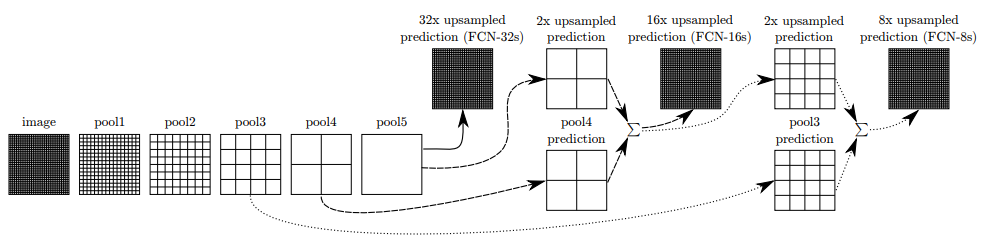

encoder와 decoder를 모두 연결해서 하나의 모델로 구성합니다.

In [72]:
def segmentation_model():
    '''
    인코더와 디코더를 함께 연결하여 최종 segmentation 모델을 정의합니다.
 
    Returns:
        segmentation 모델의 인코더와 디코더 네트워크를 연결하는 케라스 모델
    '''
 
    inputs = tf.keras.layers.Input(shape=(224,224,3,))
    convs = VGG_16(inputs)
    fcn32, fcn16, fcn8 = decoder(convs, 12)
    model_fcn32 = tf.keras.Model(inputs, fcn32)
    model_fcn16 = tf.keras.Model(inputs, fcn16)
    model_fcn8 = tf.keras.Model(inputs, fcn8)
 
    return model_fcn32, model_fcn16, model_fcn8
    
model_fcn32, model_fcn16, model_fcn8 = segmentation_model()

**모델 컴파일**

In [73]:
sgd = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True)
model_fcn32.compile(loss='categorical_crossentropy',
                    optimizer=sgd,
                    metrics=['acc'])
model_fcn16.compile(loss='categorical_crossentropy',
                    optimizer=sgd,
                    metrics=['acc'])
model_fcn8.compile(loss='categorical_crossentropy',
                   optimizer=sgd,
                   metrics=['acc'])

**모델 학습**
- 50 에포크만 진행

In [74]:
# number of training images
train_count = len(training_image_paths)
 
# number of validation images
valid_count = len(validation_image_paths)
 
steps_per_epoch = train_count//BATCH_SIZE
validation_steps = valid_count//BATCH_SIZE

In [75]:
# TensorFlow에서 GPU를 사용하는지 여부를 확인합니다.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("GPU를 사용합니다:", gpu)
else:
    print("GPU를 사용할 수 없습니다.")

GPU를 사용합니다: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [76]:
history_fcn32 = model_fcn32.fit(training_dataset,
                                steps_per_epoch=steps_per_epoch,
                                validation_data=validation_dataset,
                                validation_steps=validation_steps,
                                epochs=50)

Epoch 1/50
5/5 [==============================] - 6s 1s/step - loss: 2.4847 - acc: 0.0903 - val_loss: 2.4844 - val_acc: 0.1043
Epoch 2/50
5/5 [==============================] - 5s 1s/step - loss: 2.4839 - acc: 0.1245 - val_loss: 2.4834 - val_acc: 0.1499
Epoch 3/50
5/5 [==============================] - 5s 1s/step - loss: 2.4827 - acc: 0.1836 - val_loss: 2.4820 - val_acc: 0.2170
Epoch 4/50
5/5 [==============================] - 5s 1s/step - loss: 2.4812 - acc: 0.2561 - val_loss: 2.4803 - val_acc: 0.2811
Epoch 5/50
5/5 [==============================] - 5s 1s/step - loss: 2.4790 - acc: 0.3241 - val_loss: 2.4779 - val_acc: 0.3164
Epoch 6/50
5/5 [==============================] - 5s 1s/step - loss: 2.4758 - acc: 0.3618 - val_loss: 2.4745 - val_acc: 0.3278
Epoch 7/50
5/5 [==============================] - 5s 1s/step - loss: 2.4716 - acc: 0.3575 - val_loss: 2.4691 - val_acc: 0.3271
Epoch 8/50
5/5 [==============================] - 5s 1s/step - loss: 2.4641 - acc: 0.3575 - val_loss: 2.4595 - 

In [77]:
history_fcn16 = model_fcn16.fit(training_dataset,
                                steps_per_epoch=steps_per_epoch,
                                validation_data=validation_dataset,
                                validation_steps=validation_steps,
                                epochs=50)

Epoch 1/50
5/5 [==============================] - 5s 937ms/step - loss: 2.6886 - acc: 0.0788 - val_loss: 2.4867 - val_acc: 0.0818
Epoch 2/50
5/5 [==============================] - 4s 917ms/step - loss: 2.4845 - acc: 0.0845 - val_loss: 2.4841 - val_acc: 0.0863
Epoch 3/50
5/5 [==============================] - 4s 886ms/step - loss: 2.4823 - acc: 0.0913 - val_loss: 2.4816 - val_acc: 0.0973
Epoch 4/50
5/5 [==============================] - 4s 874ms/step - loss: 2.4784 - acc: 0.1016 - val_loss: 2.4761 - val_acc: 0.1062
Epoch 5/50
5/5 [==============================] - 4s 871ms/step - loss: 2.4690 - acc: 0.1160 - val_loss: 2.4642 - val_acc: 0.1228
Epoch 6/50
5/5 [==============================] - 4s 871ms/step - loss: 2.4477 - acc: 0.1400 - val_loss: 2.4362 - val_acc: 0.1469
Epoch 7/50
5/5 [==============================] - 5s 922ms/step - loss: 2.3976 - acc: 0.1719 - val_loss: 2.3620 - val_acc: 0.1854
Epoch 8/50
5/5 [==============================] - 4s 924ms/step - loss: 2.2956 - acc: 0.22

In [78]:
history_fcn8 = model_fcn8.fit(training_dataset,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=validation_dataset,
                              validation_steps=validation_steps,
                              epochs=50)

Epoch 1/50
5/5 [==============================] - 5s 931ms/step - loss: 3.4449 - acc: 0.0853 - val_loss: 2.4862 - val_acc: 0.0793
Epoch 2/50
5/5 [==============================] - 4s 913ms/step - loss: 2.4860 - acc: 0.0765 - val_loss: 2.4856 - val_acc: 0.0779
Epoch 3/50
5/5 [==============================] - 4s 875ms/step - loss: 2.4857 - acc: 0.0775 - val_loss: 2.4844 - val_acc: 0.0877
Epoch 4/50
5/5 [==============================] - 4s 865ms/step - loss: 2.4840 - acc: 0.0893 - val_loss: 2.4817 - val_acc: 0.0964
Epoch 5/50
5/5 [==============================] - 4s 863ms/step - loss: 2.4806 - acc: 0.0998 - val_loss: 2.4780 - val_acc: 0.1021
Epoch 6/50
5/5 [==============================] - 4s 862ms/step - loss: 2.4754 - acc: 0.1079 - val_loss: 2.4724 - val_acc: 0.1080
Epoch 7/50
5/5 [==============================] - 4s 909ms/step - loss: 2.4669 - acc: 0.1153 - val_loss: 2.4601 - val_acc: 0.1185
Epoch 8/50
5/5 [==============================] - 4s 911ms/step - loss: 2.4481 - acc: 0.13

**모델 평가**
- validation dataset의 ground truth image와 label map를 우선 읽어옵니다.

In [79]:
def get_images_and_segments_test_arrays():
    '''
    val 세트의 하위 샘플을 테스트 세트로 가져옵니다.
 
    Returns:
        Ground Truth 이미지와 레이블 맵이 포함된 테스트 세트
    '''
 
    y_true_segments = []
    y_true_images = []
    test_count = 64
 
    ds = validation_dataset.unbatch()
    ds = ds.batch(101)
 
    for image, annotation in ds.take(1):
        y_true_images = image
        y_true_segments = annotation
    
    y_true_segments = y_true_segments[:test_count, :, :, :]
    y_true_segments = np.argmax(y_true_segments, axis=3)
 
    return y_true_images, y_true_segments
 
# load the ground truth images and segmentation masks
y_true_images, y_true_segments = get_images_and_segments_test_arrays()

model의 prediction을 얻습니다. 결과는 softmax output으로 각 클래스의 확률이므로, 가장 높은 확률의 인덱스만을 취합니다.

In [80]:
# get the model prediction
results_fcn32 = model_fcn32.predict(validation_dataset, steps=validation_steps)
results_fcn16 = model_fcn16.predict(validation_dataset, steps=validation_steps)
results_fcn8 = model_fcn8.predict(validation_dataset, steps=validation_steps)
 
# for each pixel, get the slice number which has the highest probaility
results_fcn32 = np.argmax(results_fcn32, axis=3)
results_fcn16 = np.argmax(results_fcn16, axis=3)
results_fcn8 = np.argmax(results_fcn8, axis=3)

In [81]:
results_fcn8

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [3, 3, 3, ..., 

모델을 평가하기 위해 IoU와 Dice Score를 계산하는 함수를 정의하고 평가해보도록 하겠습니다.

- IoU(Intersection over Union)은 true label와 pred label의 겹치는 부분의 넓이를 두 라벨이 차지하는 넓이로 나누어준 값으로, 0~1 사이의 값을 갖습니다.

- Dice Score는 라벨의 겹치는 부분의 넓이를 두 라벨의 각각의 넓이를 합한 값으로 나누어서 2를 곱한 값이며, 이값 또한 0~1 사이의 값을 갖습니다.

두 평가지표는 모두 이미지나 영상처리에서 사용되는 지표로 1에 가까울수록 segmentation이 잘 되었다는 것을 의미합니다.

In [82]:
def compute_metrics(y_true, y_pred):
    '''
    Compute IoU and Dice Score
 
    Args:
        y_true(tensor) -- ground truth label map
        y_pred(tensor) -- predicted label map
    '''
 
    class_wise_iou = []
    class_wise_dice_score = []
 
    smoothening_factor = 0.00001
 
    for i in range(12):
        intersection = np.sum((y_pred == i) * (y_true == i))
        y_true_area = np.sum((y_true == i))
        y_pred_area = np.sum((y_pred == i))
        combined_area = y_true_area + y_pred_area
 
        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)
 
        dice_score = 2*((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        class_wise_dice_score.append(dice_score)
 
    return class_wise_iou, class_wise_dice_score

이제 결과의 IoU와 Dice Score를 구하고, 예측결과를 살펴보도록 하겠습니다.

**실제 네이버에서 이미지 하나를 찾아서 실행해보니 아래와 같이 잘 구분이되었습니다** <br>
(학습과정상 약간 오류가 생기겠지만 확인용으로는 괜찮을 듯...)

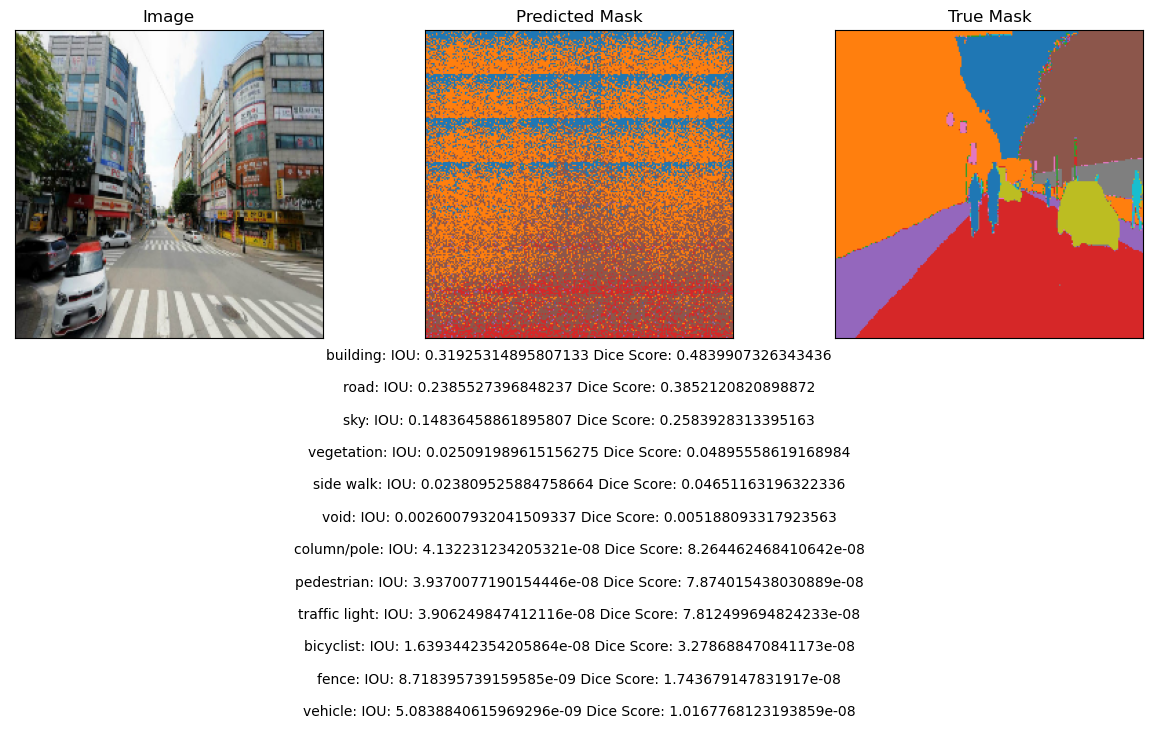

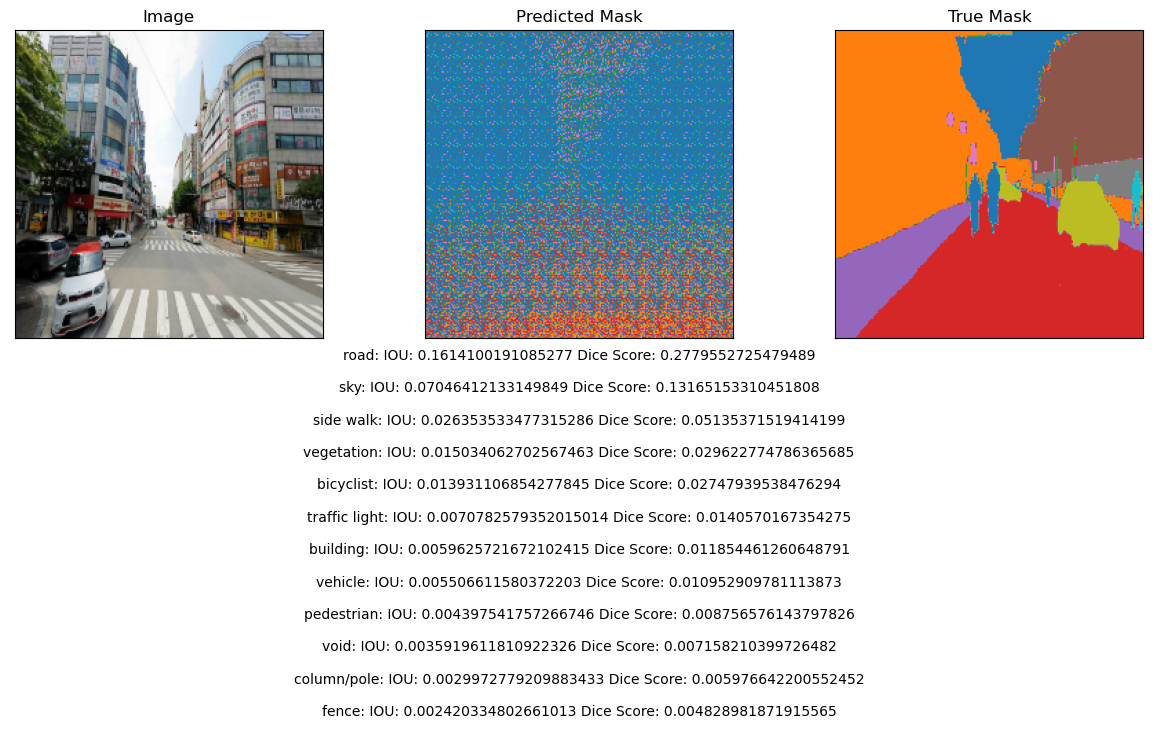

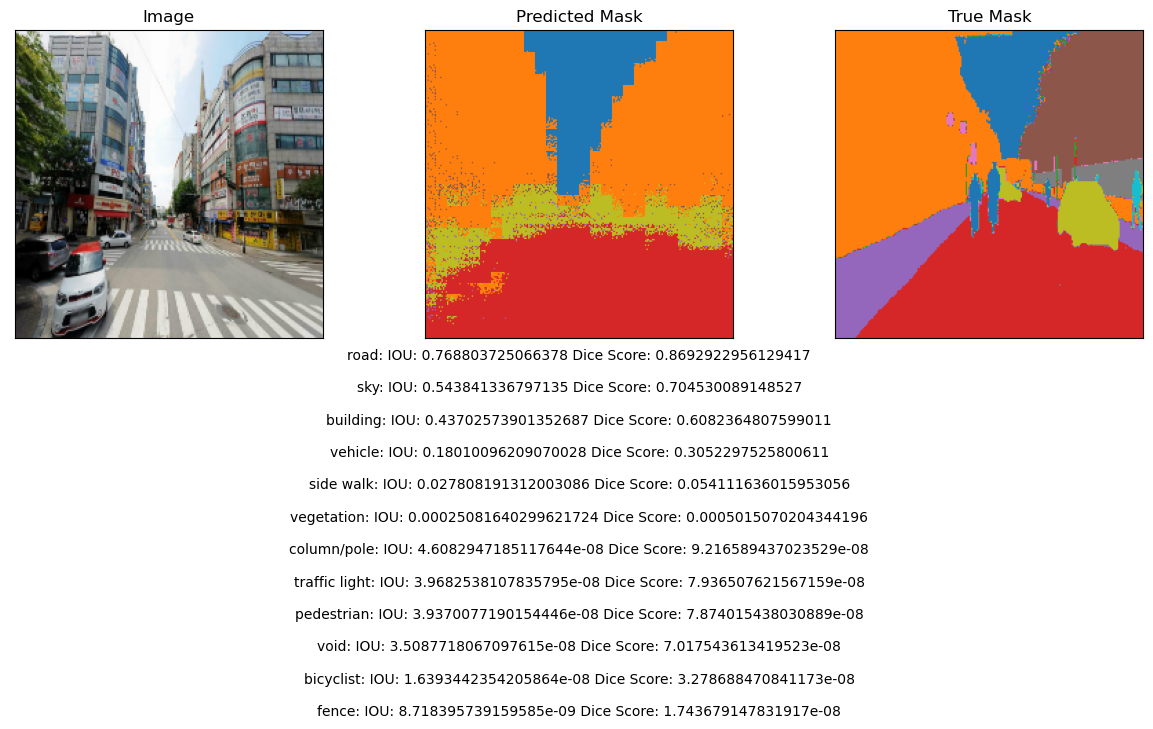

In [83]:
# input a number from 0 to 63 to pick an image from the test set
integer_slider = 1
 
# compute metrics
iou_fcn32, dice_score_fcn32 = compute_metrics(y_true_segments[integer_slider], results_fcn32[integer_slider])
iou_fcn16, dice_score_fcn16 = compute_metrics(y_true_segments[integer_slider], results_fcn16[integer_slider])
iou_fcn8, dice_score_fcn8 = compute_metrics(y_true_segments[integer_slider], results_fcn8[integer_slider])
 
# visualize the output and metrics
show_predictions(y_true_images[integer_slider], [results_fcn32[integer_slider], y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"], iou_fcn32, dice_score_fcn32)
show_predictions(y_true_images[integer_slider], [results_fcn16[integer_slider], y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"], iou_fcn16, dice_score_fcn16)
show_predictions(y_true_images[integer_slider], [results_fcn8[integer_slider], y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"], iou_fcn8, dice_score_fcn8)


FCN-8의 경우에는 아주 정확하지는 않지만, 대체로 큼지막한 구역들은 정상적으로 구분하고 있습니다.

마지막으로 클래스 별로 각 모델들의 IoU와 Dice Score을 계산해보도록 하겠습니다.

In [42]:
# compute class-wise metrics
cls_wise_iou_fcn32, cls_wise_dice_score_fcn32 = compute_metrics(y_true_segments, results_fcn32)
cls_wise_iou_fcn16, cls_wise_dice_score_fcn16 = compute_metrics(y_true_segments, results_fcn16)
cls_wise_iou_fcn8, cls_wise_dice_score_fcn8 = compute_metrics(y_true_segments, results_fcn8)

**IOU**

In [43]:
# print IOU for each class
print('FCN-32')
for idx, iou in enumerate(cls_wise_iou_fcn32):
    spaces = ' ' * (13-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, iou)) 
print('FCN-16')
for idx, iou in enumerate(cls_wise_iou_fcn16):
    spaces = ' ' * (13-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, iou))
print('FCN-8')
for idx, iou in enumerate(cls_wise_iou_fcn8):
    spaces = ' ' * (13-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, iou)) 

FCN-32
sky            0.23419097873114184 
building       0.24850095416719628 
column/pole    4.3717758134249476e-10 
road           0.6768741617307568 
side walk      0.00017869349994110347 
vegetation     0.021628199219247933 
traffic light  2.969826561246785e-10 
fence          1.328268203739305e-10 
vehicle        1.2321008339721178e-05 
pedestrian     4.5793836128683506e-10 
bicyclist      1.7459319781852902e-10 
void           2.887919830511474e-10 
FCN-16
sky            0.06979844598238406 
building       0.1258117736307404 
column/pole    0.0023818098976980057 
road           0.6622016458243882 
side walk      0.04558836913793957 
vegetation     0.16011425470831678 
traffic light  0.0073040841853713725 
fence          0.003235799605779815 
vehicle        0.03619202775817746 
pedestrian     0.0014098953253824254 
bicyclist      8.63828132949133e-05 
void           0.01453576883285088 
FCN-8
sky            0.8348401607983639 
building       0.71918511353747 
column/pole    4.3717

**DICE**

In [48]:
# print DICE for each class
print('FCN-32')
for idx, iou in enumerate(cls_wise_dice_score_fcn32):
    spaces = ' ' * (13-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, iou)) 
print('FCN-16')
for idx, iou in enumerate(cls_wise_dice_score_fcn16):
    spaces = ' ' * (13-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, iou))
print('FCN-8')
for idx, iou in enumerate(cls_wise_dice_score_fcn8):
    spaces = ' ' * (13-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, iou)) 

FCN-32
sky            0.37950525124327 
building       0.39807891750404484 
column/pole    8.743551626849895e-10 
road           0.807304659087039 
side walk      0.0003573231485693811 
vegetation     0.042340646501512404 
traffic light  5.93965312249357e-10 
fence          2.65653640747861e-10 
vehicle        2.464171307172617e-05 
pedestrian     9.158767225736701e-10 
bicyclist      3.4918639563705804e-10 
void           5.775839661022948e-10 
FCN-16
sky            0.13048896499202295 
building       0.22350410002566462 
column/pole    0.004752300719820877 
road           0.796776549332584 
side walk      0.08720137003208216 
vegetation     0.2760318719637128 
traffic light  0.014502242771057345 
fence          0.006450725955863693 
vehicle        0.06985583133545743 
pedestrian     0.002815820639610982 
bicyclist      0.00017275070392786795 
void           0.0286550149972517 
FCN-8
sky            0.9099867973769157 
building       0.8366581444641751 
column/pole    8.743551626849895